In [ ]:
!nvidia-smi

Sat Jul 19 04:10:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P0             27W /   70W |    1634MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/openai/CLIP.git

Cloning into 'CLIP'...
remote: Enumerating objects: 256, done.
remote: Total 256 (delta 0), reused 0 (delta 0), pack-reused 256 (from 1)
Receiving objects: 100% (256/256), 8.93 MiB | 16.68 MiB/s, done.
Resolving deltas: 100% (133/133), done.


In [ ]:
!git clone https://github.com/CompVis/taming-transformers

Cloning into 'taming-transformers'...
remote: Enumerating objects: 1342, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 1342 (delta 0), reused 0 (delta 0), pack-reused 1341 (from 2)
Receiving objects: 100% (1342/1342), 409.77 MiB | 30.96 MiB/s, done.
Resolving deltas: 100% (282/282), done.


In [ ]:
!pip install --no-deps ftfy regex tqdm
!pip install omegaconf==2.0.0 pytorch-lightning==1.0.8
!pip uninstall torchtext --yes
!pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.7 MB/s eta 0:00:00
  Attempting uninstall: omegaconf
    Foun

In [ ]:
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import torch, os, imageio, pdb, math
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF

In [ ]:
import yaml
from omegaconf import OmegaConf

from CLIP import clip

import warnings
warnings.filterwarnings('ignore')

In [ ]:
## helper functions

def show_from_tensor(tensor):
  img = tensor.clone()
  img = img.mul(255).byte()
  img = img.cpu().numpy().transpose((1,2,0))

  plt.figure(figsize=(10,7))
  plt.axis('off')
  plt.imshow(img)
  plt.show()

def norm_data(data):
  return (data.clip(-1,1)+1)/2 ### range between 0 and 1 in the result

### Parameters
learning_rate = .5
batch_size = 1
wd = .1
noise_factor = .22

total_iter=400
im_shape = [450, 450, 3] # height, width, channel
size1, size2, channels = im_shape

In [ ]:
### CLIP MODEL ###

clipmodel, _ = clip.load('ViT-B/32', jit=False) # jit = just intime
clipmodel.eval()
print(clip.available_models())

print("Clip model visual input resolution: ", clipmodel.visual.input_resolution)

device=torch.device("cuda:0")
torch.cuda.empty_cache()

100%|███████████████████████████████████████| 338M/338M [00:11<00:00, 31.4MiB/s]


['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']
Clip model visual input resolution:  224


In [ ]:
## Taming transformer instantiation

%cd taming-transformers/

!mkdir -p models/vqgan_imagenet_f16_16384/checkpoints
!mkdir -p models/vqgan_imagenet_f16_16384/configs

if len(os.listdir('models/vqgan_imagenet_f16_16384/checkpoints/')) == 0:
   !wget 'https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1&#39' -O 'models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt'
   !wget 'https://heibox.uni-heidelberg.de/f/274fb24ed38341bfa753/?dl=1&#39' -O 'models/vqgan_imagenet_f16_16384/configs/model.yaml'

/content/taming-transformers
--2025-07-19 03:24:10--  https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1&
Resolving heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)... 129.206.7.113
Connecting to heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)|129.206.7.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://heibox.uni-heidelberg.de/seafhttp/files/fd64e492-9d20-454d-9908-89b11abde89c/last.ckpt [following]
--2025-07-19 03:24:11--  https://heibox.uni-heidelberg.de/seafhttp/files/fd64e492-9d20-454d-9908-89b11abde89c/last.ckpt
Reusing existing connection to heibox.uni-heidelberg.de:443.
HTTP request sent, awaiting response... 200 OK
Length: 980092370 (935M) [application/octet-stream]
Saving to: ‘models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt’

models/vqgan_imagen 100%[===================>] 934.69M  12.8MB/s    in 63s     

2025-07-19 03:25:15 (14.8 MB/s) - ‘models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt’ saved [980092370/98

In [ ]:
import numpy as np
np.Inf = np.inf

In [ ]:
from taming.models.vqgan import VQModel

def load_config(config_path, display=False):
   config_data = OmegaConf.load(config_path)
   if display:
     print(yaml.dump(OmegaConf.to_container(config_data)))
   return config_data

def load_vqgan(config, chk_path=None):
  model = VQModel(**config.model.params)
  if chk_path is not None:
    state_dict = torch.load(chk_path, map_location="cpu")["state_dict"]
    missing, unexpected = model.load_state_dict(state_dict, strict=False)
  return model.eval()

def generator(x):
  x = taming_model.post_quant_conv(x)
  x = taming_model.decoder(x)
  return x

taming_config = load_config("./models/vqgan_imagenet_f16_16384/configs/model.yaml", display=True)
taming_model = load_vqgan(taming_config, chk_path="./models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt").to(device)

model:
  base_learning_rate: 4.5e-06
  params:
    ddconfig:
      attn_resolutions:
      - 16
      ch: 128
      ch_mult:
      - 1
      - 1
      - 2
      - 2
      - 4
      double_z: false
      dropout: 0.0
      in_channels: 3
      num_res_blocks: 2
      out_ch: 3
      resolution: 256
      z_channels: 256
    embed_dim: 256
    lossconfig:
      params:
        codebook_weight: 1.0
        disc_conditional: false
        disc_in_channels: 3
        disc_num_layers: 2
        disc_start: 0
        disc_weight: 0.75
      target: taming.modules.losses.vqperceptual.VQLPIPSWithDiscriminator
    monitor: val/rec_loss
    n_embed: 16384
  target: taming.models.vqgan.VQModel

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 164MB/s]


8.19kB [00:00, 572kB/s]                    

loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint was not an allowed global by default. Please use `torch.serialization.add_safe_globals([ModelCheckpoint])` or the `torch.serialization.safe_globals([ModelCheckpoint])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [ ]:
from taming.models.vqgan import VQModel
import torch
from omegaconf import OmegaConf
import yaml
import torchvision # Added import

def load_config(config_path, display=False):
  config_data = OmegaConf.load(config_path)
  if display:
    print(yaml.dump(OmegaConf.to_container(config_data)))
    return config_data

def load_vqgan(config, chk_path=None):
  model = VQModel(**config.model.params)
  if chk_path is not None:
    state_dict = torch.load(chk_path, map_location="cpu", weights_only=False)["state_dict"] # Added weights_only=False
    missing, unexpected = model.load_state_dict(state_dict, strict=False)
    return model.eval()

def generator(x):
  x = taming_model.post_quant_conv(x)
  x = taming_model.decoder(x)
  return x

taming_config = load_config("./models/vqgan_imagenet_f16_16384/configs/model.yaml", display=True)
taming_model = load_vqgan(taming_config, chk_path="./models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt").to(device)

model:
  base_learning_rate: 4.5e-06
  params:
    ddconfig:
      attn_resolutions:
      - 16
      ch: 128
      ch_mult:
      - 1
      - 1
      - 2
      - 2
      - 4
      double_z: false
      dropout: 0.0
      in_channels: 3
      num_res_blocks: 2
      out_ch: 3
      resolution: 256
      z_channels: 256
    embed_dim: 256
    lossconfig:
      params:
        codebook_weight: 1.0
        disc_conditional: false
        disc_in_channels: 3
        disc_num_layers: 2
        disc_start: 0
        disc_weight: 0.75
      target: taming.modules.losses.vqperceptual.VQLPIPSWithDiscriminator
    monitor: val/rec_loss
    n_embed: 16384
  target: taming.models.vqgan.VQModel

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


torch.Size([1, 256, 16, 28])
img dimensions:  torch.Size([1, 3, 256, 448])


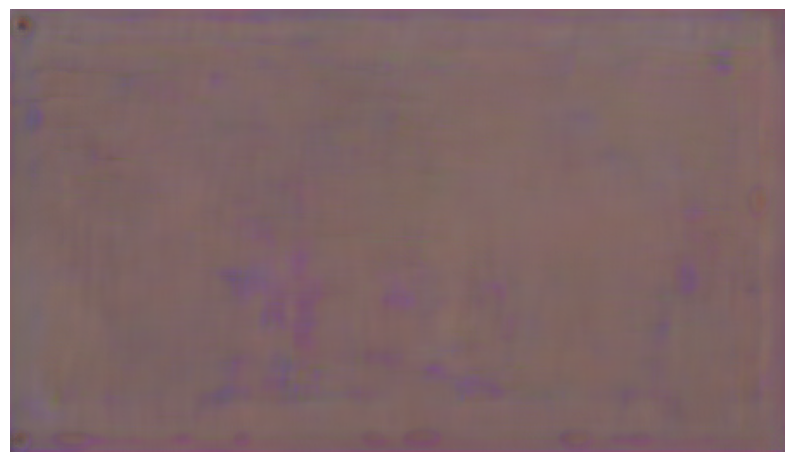

In [ ]:
import torch
import torchvision

# Define your parameter initialization
def init_params():
    # 256 is the expected latent channel count for your generator
    params = torch.nn.Parameter(torch.randn(1, 256, 16, 28).cuda())  # Example: [1, 256, H, W]
    optimizer = torch.optim.Adam([params], lr=0.05)
    return params, optimizer

### Encoding prompts and a few more things
normalize = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

def encodeText(text):
  t=clip.tokenize(text).cuda()
  t=clipmodel.encode_text(t).detach().clone()
  return t

def createEncodings(include, exclude, extras):
  include_enc=[]
  for text in include:
    include_enc.append(encodeText(text))
  exclude_enc=encodeText(exclude) if exclude != '' else 0
  extras_enc=encodeText(extras) if extras !='' else 0

  return include_enc, exclude_enc, extras_enc

augTransform = torch.nn.Sequential(
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomAffine(30, (.2, .2), fill=0)
).cuda()

Params, optimizer = init_params()

with torch.no_grad():
    print(Params.shape)
    img = norm_data(generator(Params).cpu())
    print("img dimensions: ", img.shape)
    show_from_tensor(img[0])


In [ ]:
### create crops

def create_crops(img, num_crops=32):
  p=size1//2
  img = torch.nn.functional.pad(img, (p,p,p,p), mode='constant', value=0) # 1 x 3 x 448 x 624 (adding 112*2 on all sides to 224x400)

  img = augTransform(img) #RandomHorizontalFlip and RandomAffine

  crop_set = []
  for ch in range(num_crops):
    gap1= int(torch.normal(1.2, .3, ()).clip(.43, 1.9) * size1)
    offsetx = torch.randint(0, int(size1*2-gap1),())
    offsety = torch.randint(0, int(size1*2-gap1),())

    crop=img[:,:,offsetx:offsetx+gap1, offsety:offsety+gap1]

    crop = torch.nn.functional.interpolate(crop,(224,224), mode='bilinear', align_corners=True)
    crop_set.append(crop)

  img_crops=torch.cat(crop_set,0) ## 30 x 3 x 224 x 224

  randnormal = torch.randn_like(img_crops, requires_grad=False)
  num_rands=0
  randstotal=torch.rand((img_crops.shape[0],1,1,1)).cuda() #32

  for ns in range(num_rands):
    randstotal*=torch.rand((img_crops.shape[0],1,1,1)).cuda()

  img_crops = img_crops + noise_factor*randstotal*randnormal

  return img_crops

In [ ]:
### Show current state of generation

def showme(Params, show_crop):
  with torch.no_grad():
    generated = generator(Params) # Changed from generator(Params())

    if (show_crop):
      print("Augmented cropped example")
      aug_gen = generated.float() # 1 x 3 x 224 x 400
      aug_gen = create_crops(aug_gen, num_crops=1)
      aug_gen_norm = norm_data(aug_gen[0])
      show_from_tensor(aug_gen_norm)

    print("Generation")
    latest_gen=norm_data(generated.cpu()) # 1 x 3 x 224 x 400
    show_from_tensor(latest_gen[0])

  return (latest_gen[0])

In [ ]:
# Optimization process

def optimize_result(Params, prompt):
  alpha=1 ## the importance of the include encodings
  beta=.5 ## the importance of the exclude encodings

  ## image encoding
  out = generator(Params) # Changed from generator(Params())
  out = norm_data(out)
  out = create_crops(out)
  out = normalize(out) # 30 x 3 x 224 x 224
  image_enc=clipmodel.encode_image(out) ## 30 x 512

  ## text encoding  w1 and w2
  final_enc = w1*prompt + w1*extras_enc # prompt and extras_enc : 1 x 512
  final_text_include_enc = final_enc / final_enc.norm(dim=-1, keepdim=True) # 1 x 512
  final_text_exclude_enc = exclude_enc

  ## calculate the loss
  main_loss = torch.cosine_similarity(final_text_include_enc, image_enc, -1) # 30
  penalize_loss = torch.cosine_similarity(final_text_exclude_enc, image_enc, -1) # 30

  final_loss = -alpha*main_loss + beta*penalize_loss

  return final_loss

def optimize(Params, optimizer, prompt):
  loss = optimize_result(Params, prompt).mean()
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss

In [ ]:
### training loop

def training_loop(Params, optimizer, show_crop=False):
  res_img=[]
  res_z=[]

  for prompt in include_enc:
    iteration=0
    Params, optimizer = init_params() # 1 x 256 x 14 x 25 (225/16, 400/16)

    for it in range(total_iter):
      loss = optimize(Params, optimizer, prompt)

      if iteration>=80 and iteration%show_step == 0:
        new_img = showme(Params, show_crop) # Changed from showme(Params(), show_crop)
        res_img.append(new_img)
        res_z.append(Params) # Changed from res_z.append(Params())
        print("loss:", loss.item(), "\niteration:",iteration)

      iteration+=1
    torch.cuda.empty_cache()
  return res_img, res_z

Augmented cropped example


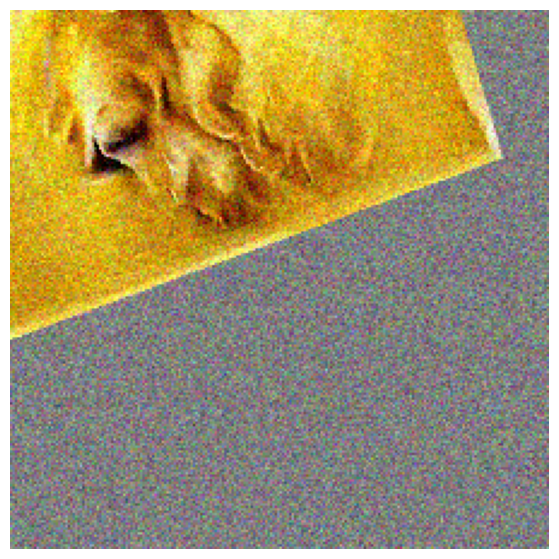

Generation


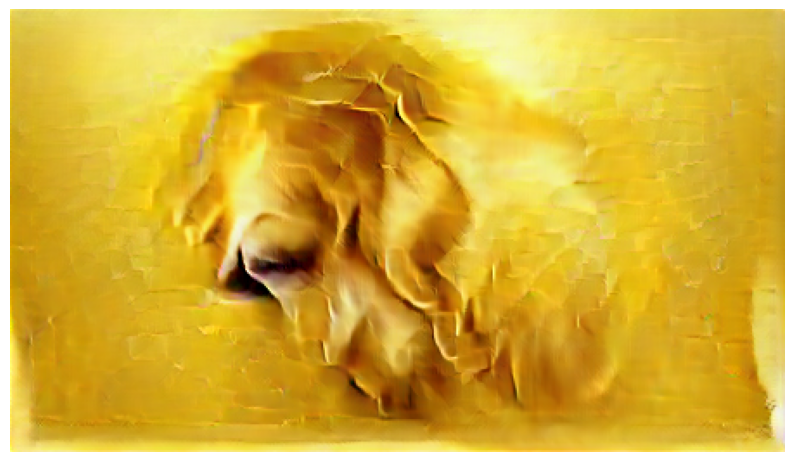

loss: -0.1939697265625 
iteration: 80
Augmented cropped example


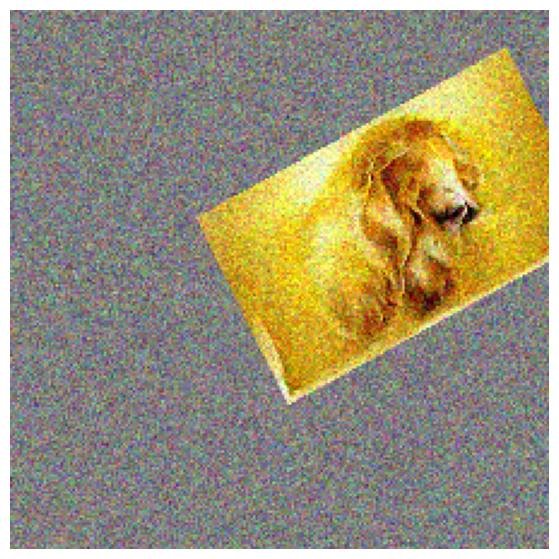

Generation


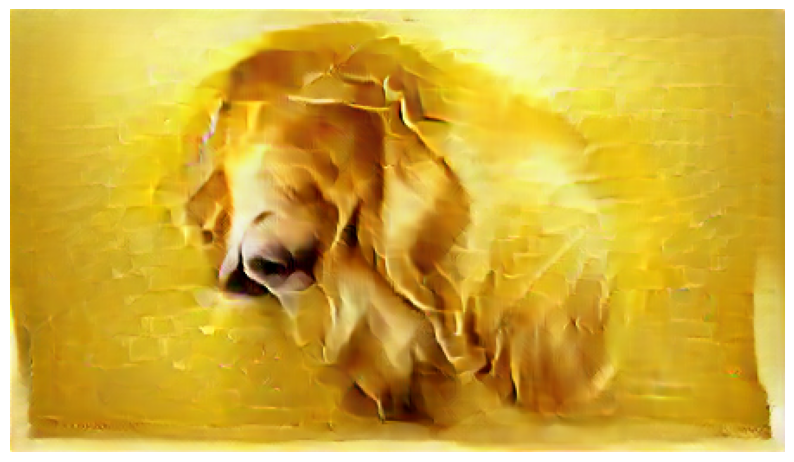

loss: -0.2015380859375 
iteration: 90
Augmented cropped example


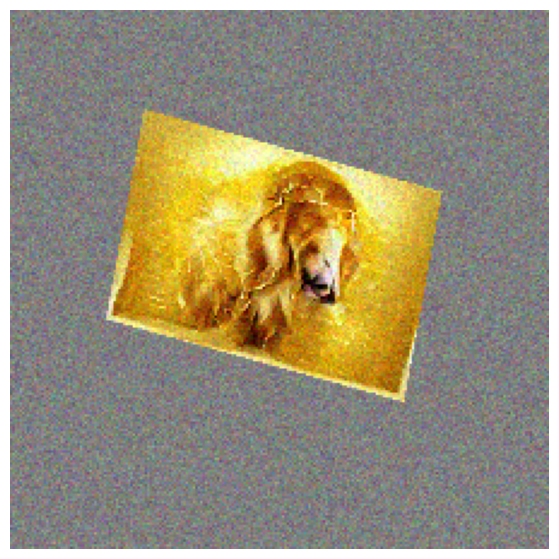

Generation


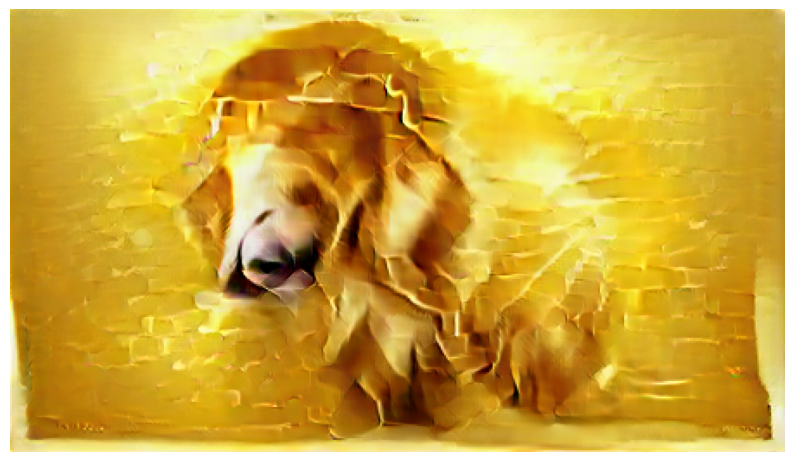

loss: -0.2049560546875 
iteration: 100


In [ ]:
torch.cuda.empty_cache()
include=['Golden Retriever dog']
exclude='watermark'
extras = ""
w1=1
w2=1
noise_factor= .22
total_iter=110
show_step=10 # set this to see the result every 10 interations beyond iteration 80
include_enc, exclude_enc, extras_enc = createEncodings(include, exclude, extras)
res_img, res_z=training_loop(Params, optimizer, show_crop=True)

In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git
'''ftfy = fixes text for you
regex = regular expressions
tqdm = progress bar
'''

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.3 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-9pyxhl_7
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-9pyxhl_7
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

'ftfy = fixes text for you\nregex = regular expressions\ntqdm = progress bar\n'

In [ ]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)

Torch version: 2.6.0+cu124


In [ ]:
print(torch.__version__)

2.6.0+cu124


In [ ]:
import clip
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [ ]:
model, preprocess = clip.load('ViT-B/32')
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [ ]:
# Iamge Preporcessing

In [ ]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7bacf6435e40>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [ ]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

In [ ]:
clip.tokenize("Raviteja Beri")

# 49406 = SOT (start of the text)
# 14367 = Name Tokens (14367 = Ra, 2732 = vi, etc..,)
# 49407 = EOT (end of the text)
# 0 = padding (unused positions)


tensor([[49406, 14367,  2732,  2641,   867,   328, 49407,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

In [ ]:
# setting up input images and texts

In [ ]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer"
}

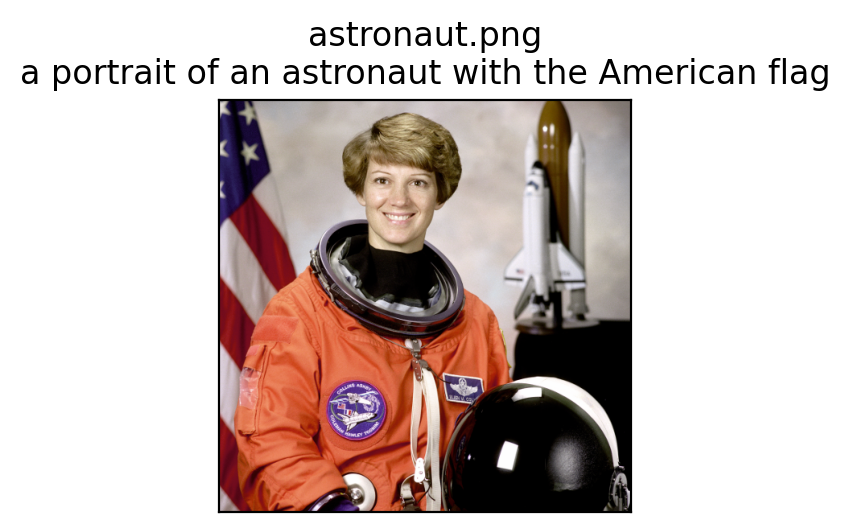

In [ ]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")

    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()


In [ ]:
import os
from skimage import data
from PIL import Image

data_dir = '/root/.cache/scikit-image/0.25.2/data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Save astronaut image as a PNG in that directory
img = data.astronaut()
img_pil = Image.fromarray(img)
img_pil.save(os.path.join(data_dir, 'astronaut.png'))


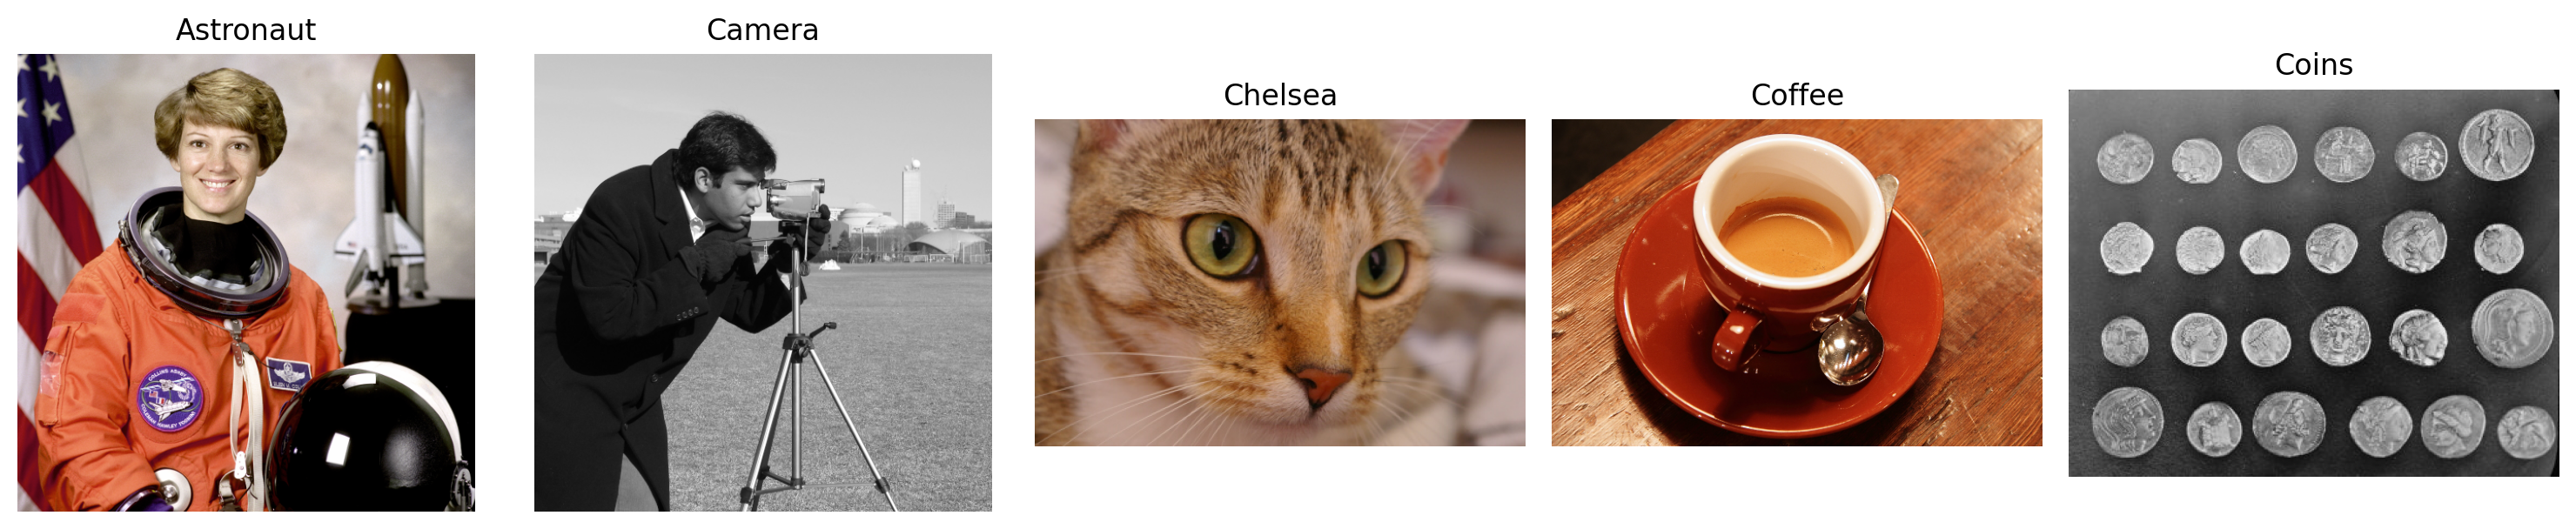

In [ ]:
from skimage import data
import matplotlib.pyplot as plt

images = [
    ("Astronaut", data.astronaut()),
    ("Camera", data.camera()),
    ("Chelsea", data.chelsea()),
    ("Coffee", data.coffee()),
    ("Coins", data.coins())
]

plt.figure(figsize=(15, 3))
for i, (name, img) in enumerate(images):
    plt.subplot(1, len(images), i + 1)
    plt.imshow(img, cmap='gray' if img.ndim == 2 else None)
    plt.title(name)
    plt.axis('off')
plt.tight_layout()


In [ ]:
# Building Features

In [ ]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [ ]:
for i, img in enumerate(images):
    print(f"Image {i} type: {type(img)}")


Image 0 type: <class 'tuple'>
Image 1 type: <class 'tuple'>
Image 2 type: <class 'tuple'>
Image 3 type: <class 'tuple'>
Image 4 type: <class 'tuple'>


In [ ]:
for i, img in enumerate(images):
    if isinstance(img, np.ndarray):
        print(f"Image {i}: NumPy array with shape {img.shape}")
    elif isinstance(img, torch.Tensor):
        print(f"Image {i}: Torch tensor with shape {img.shape}")
    elif hasattr(img, 'size'):  # PIL Image
        print(f"Image {i}: PIL image with size {img.size}")
    else:
        print(f"Image {i}: Unknown type/content -> {img}")


Image 0: Unknown type/content -> ('Astronaut', array([[[154, 147, 151],
        [109, 103, 124],
        [ 63,  58, 102],
        ...,
        [127, 120, 115],
        [120, 117, 106],
        [125, 119, 110]],

       [[177, 171, 171],
        [144, 141, 143],
        [113, 114, 124],
        ...,
        [127, 118, 112],
        [124, 115, 108],
        [121, 116, 105]],

       [[201, 194, 193],
        [182, 178, 175],
        [168, 165, 164],
        ...,
        [128, 120, 117],
        [126, 116, 112],
        [124, 114, 109]],

       ...,

       [[186, 170, 176],
        [186, 170, 177],
        [183, 168, 170],
        ...,
        [  0,   0,   0],
        [  0,   0,   1],
        [  0,   0,   0]],

       [[183, 169, 170],
        [182, 167, 171],
        [185, 164, 176],
        ...,
        [  0,   0,   1],
        [  1,   1,   1],
        [  0,   0,   0]],

       [[184, 167, 172],
        [183, 165, 169],
        [180, 162, 171],
        ...,
        [  0,   0,   0],
  

In [ ]:
from torchvision import transforms
from PIL import Image
import numpy as np
import torch

# Define the transform pipeline
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Convert to tensor with shape [C, H, W]
])

image_tensors = []

for label, img_array in images:
    # Step 1: Ensure it's 3-channel RGB
    if img_array.ndim == 2:  # grayscale
        img_array = np.stack([img_array]*3, axis=-1)
    elif img_array.shape[2] == 1:  # single channel
        img_array = np.repeat(img_array, 3, axis=2)

    # Step 2: Convert NumPy array to PIL Image
    img_pil = Image.fromarray(img_array.astype(np.uint8))

    # Step 3: Apply transforms
    img_tensor = preprocess(img_pil)
    image_tensors.append(img_tensor)

# Step 4: Stack and move to GPU
image_input = torch.stack(image_tensors).cuda()



In [ ]:
import torch

In [ ]:
import clip
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the CLIP model
model, preprocess_clip = clip.load("ViT-B/32", device=device)
model.eval()


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [ ]:
# Make sure clip is imported and device is set
import clip

# Example: use labels as text prompts
texts = [label for label, _ in images]  # just labels like "Astronaut", "Camera", etc.
# You can also add a prompt prefix:
# texts = ["a photo of a " + label for label, _ in images]

# Tokenize the text
text_tokens = clip.tokenize(texts).to(device)


In [ ]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()


In [ ]:
# calculating Cosine Similarity

In [ ]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

ValueError: The number of FixedLocator locations (8), usually from a call to set_ticks, does not match the number of labels (5).

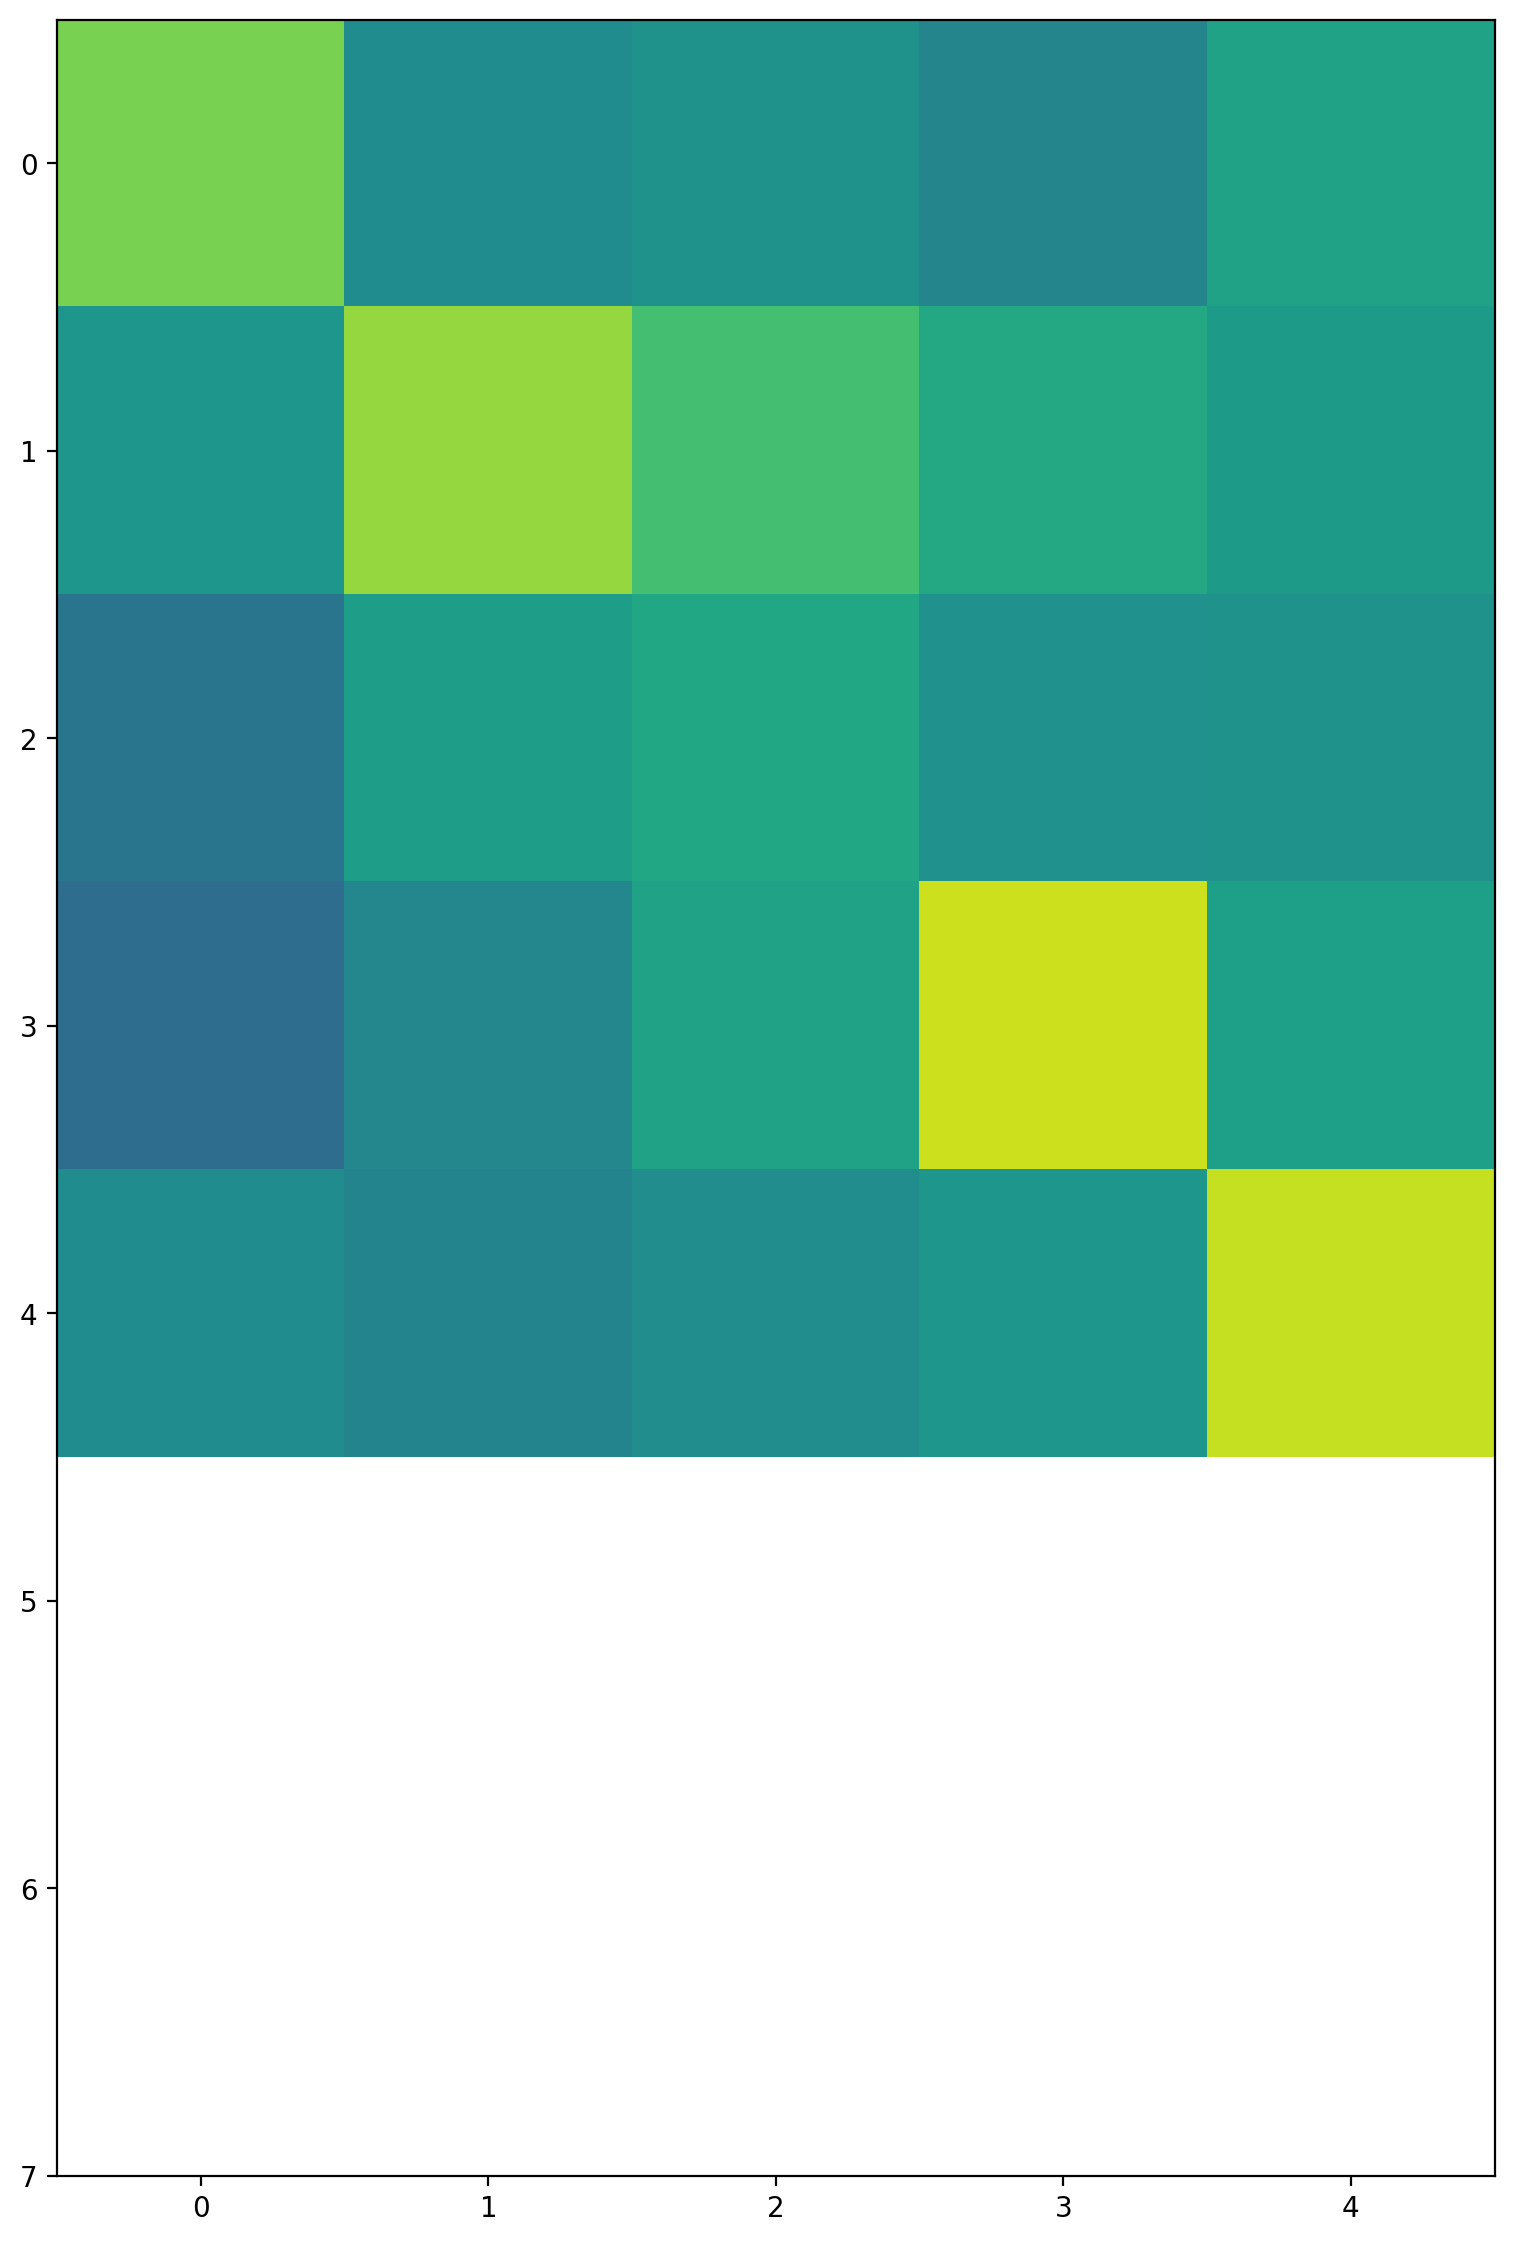

In [ ]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)